Trial 3 Complete [00h 00m 08s]
val_mae: 0.3821186125278473

Best val_mae So Far: 0.28348833322525024
Total elapsed time: 00h 00m 23s
Best Hyperparameters (Encoder–Decoder): {'enc_units': 128, 'dec_units': 96, 'learning_rate': 0.001}
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 287ms/step - loss: 0.0451 - mae: 0.1694 - val_loss: 0.1376 - val_mae: 0.3223
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0447 - mae: 0.1587 - val_loss: 0.1270 - val_mae: 0.3087
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0397 - mae: 0.1519 - val_loss: 0.1207 - val_mae: 0.3010
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0384 - mae: 0.1506 - val_loss: 0.1202 - val_mae: 0.3015
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0331 - mae: 0.1376 - val_loss: 0.1211 - val_mae: 0.3047
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0349 - mae: 0.1398 - val_loss: 0.1274 - val_mae: 0.3151
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0322 - mae: 0.1306 - val_loss: 0.1233 - val_mae: 0.3108
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0301 - mae: 0.1269 - val_loss: 0.1109 - val_mae: 0.2942
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0333 - mae: 0.1366 - val_loss: 

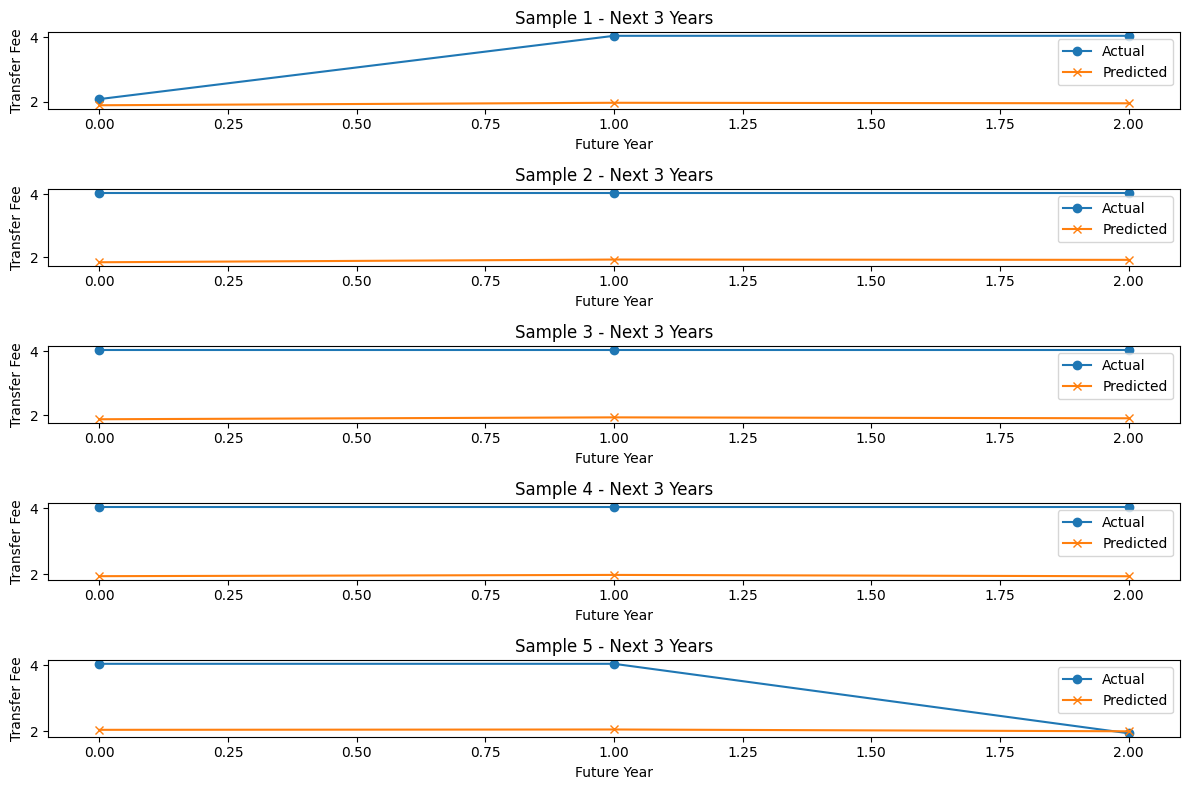

In [2]:
!pip install tensorflow scikit-learn pandas matplotlib keras-tuner
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

from google.colab import files
uploaded = files.upload()

df = pd.read_csv("final_player_dataset.csv")
features = ['season_minutes_played', 'season_games_played', 'injury_risk_score', 'Sentiment_Score', 'Weighted_Sentiment']
target = 'Log_Fee'
df = df.dropna(subset=features+[target])

X = df[features].values
y = df[target].values.reshape(-1,1)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

def create_sequences(X, y, timesteps=3):
    Xs, ys = [], []
    for i in range(len(X)-timesteps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)

timesteps = 3
X_seq, y_seq = create_sequences(X_scaled, y_scaled, timesteps)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int("units", 32, 256, step=32), activation="tanh", input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(hp.Int("dense_units", 16, 128, step=16), activation="relu"))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), loss="mse", metrics=["mae"])
    return model

tuner = kt.RandomSearch(build_model, objective="val_mae", max_trials=5, executions_per_trial=2, directory="lstm_tuning", project_name="player_fee")
tuner.search(X_train, y_train, epochs=30, validation_split=0.2)
best_model = tuner.get_best_models(1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:", best_hp.values)

history = best_model.fit(X_train, y_train, epochs=50, validation_split=0.2)
loss, mae = best_model.evaluate(X_test, y_test)
print("LSTM Test MAE:", mae)

y_pred_scaled = best_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

results = pd.DataFrame({"Actual_Fee": y_true.flatten(), "Predicted_Fee": y_pred.flatten()})
print(results.head(10))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

future_steps = 3

def create_sequences_multistep(X, y, timesteps=3, future_steps=3):
    Xs, ys = [], []
    for i in range(len(X) - timesteps - future_steps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps:i+timesteps+future_steps])
    return np.array(Xs), np.array(ys)

X_seq_multi, y_seq_multi = create_sequences_multistep(X_scaled, y_scaled, timesteps=3, future_steps=future_steps)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_seq_multi, y_seq_multi, test_size=0.2, shuffle=False)

def build_encoder_decoder(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int("enc_units", 32, 128, step=32), activation="tanh", input_shape=(X_train_m.shape[1], X_train_m.shape[2])))
    model.add(RepeatVector(future_steps))
    model.add(LSTM(units=hp.Int("dec_units", 32, 128, step=32), activation="tanh", return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer=Adam(learning_rate=hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), loss="mse", metrics=["mae"])
    return model

tuner_ed = kt.RandomSearch(build_encoder_decoder, objective="val_mae", max_trials=3, executions_per_trial=1, directory="lstm_tuning", project_name="encoder_decoder_fee")
tuner_ed.search(X_train_m, y_train_m, epochs=20, validation_split=0.2)
best_model_ed = tuner_ed.get_best_models(1)[0]
best_hp_ed = tuner_ed.get_best_hyperparameters(1)[0]
print("Best Hyperparameters (Encoder–Decoder):", best_hp_ed.values)

history_ed = best_model_ed.fit(X_train_m, y_train_m, epochs=50, validation_split=0.2)
loss, mae = best_model_ed.evaluate(X_test_m, y_test_m)
print("Encoder–Decoder Test MAE:", mae)

y_pred_multi_scaled = best_model_ed.predict(X_test_m)
y_pred_multi = scaler_y.inverse_transform(y_pred_multi_scaled.reshape(-1,1))
y_true_multi = scaler_y.inverse_transform(y_test_m.reshape(-1,1))
y_pred_multi = y_pred_multi.reshape(-1, future_steps)
y_true_multi = y_true_multi.reshape(-1, future_steps)

num_samples_to_plot = 5
plt.figure(figsize=(12, 8))
for i in range(num_samples_to_plot):
    plt.subplot(num_samples_to_plot, 1, i+1)
    plt.plot(range(future_steps), y_true_multi[i], marker='o', label="Actual")
    plt.plot(range(future_steps), y_pred_multi[i], marker='x', label="Predicted")
    plt.title(f"Sample {i+1} - Next {future_steps} Years")
    plt.xlabel("Future Year")
    plt.ylabel("Transfer Fee")
    plt.legend()
plt.tight_layout()
plt.show()
